# Surrogate Modeling for Reservoir Simulation using PyTorch
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Reservoir Simulation & History Matching

## Introduction
In this notebook, we will build a Deep Learning model to act as a fast proxy for a reservoir simulator. 
We will predict **Cumulative Oil Production** based on geological and reservoir characteristics.

### Objective
To replace computationally expensive physics-based simulations with a fast neural network inference engine.

### Inputs (Features)
1.  Porosity
2.  Permeability (mD)
3.  Initial Pressure (psi)
4.  Water Saturation
5.  Reservoir Thickness (ft)

### Output (Target)
* Cumulative Oil Production (bbl)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-Learn for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

# Configuration
# Check for Apple Silicon (MPS) first, then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"MPS (Apple Metal) available: {torch.backends.mps.is_available()}")
print(f"MPS (Apple Metal) built: {torch.backends.mps.is_built()}")

PyTorch version: 2.8.0
MPS (Apple Metal) available: True
MPS (Apple Metal) built: True


## 1. Data Loading and Exploration
We begin by loading the simulation results. In a real-world scenario, this CSV would be the result of running a Sensitivity Analysis or Latin Hypercube Sampling (LHS) on your simulator (e.g., Eclipse/tNav).

Dataset Shape: (2000, 6)


,Porosity,Permeability_mD,Initial_Pressure_psi,Water_Saturation,Thickness_ft,Cum_Oil_Prod_bbl
0,0.224908,246.279263,3643.991757,0.294477,77.621434,343130.754008
1,0.340143,235.234099,4110.864659,0.151716,74.982640,659535.411865
2,0.296399,729.690935,4020.321860,0.361718,27.660336,316626.212336
3,0.269732,237.159650,2807.799809,0.283935,93.805792,405206.613596
4,0.181204,253.962295,2798.498939,0.147161,65.477776,249949.322910


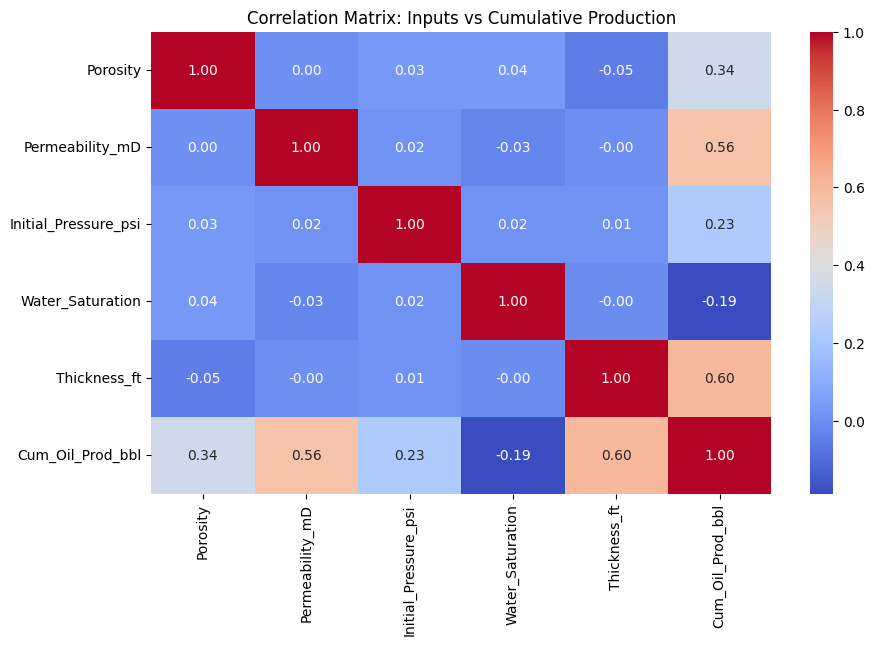

In [3]:
# Load Data
df = pd.read_csv('reservoir_simulation_data.csv')

# Quick inspection
print(f"Dataset Shape: {df.shape}")
display(df.head())

# Visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Inputs vs Cumulative Production")
plt.show()

## 2. Data Preprocessing
Neural Networks converge faster and perform better when inputs are scaled. We will use `StandardScaler` to normalize features to mean 0 and standard deviation 1.

In [4]:
# Define Features (X) and Target (y)
X_raw = df.drop('Cum_Oil_Prod_bbl', axis=1).values
y_raw = df[['Cum_Oil_Prod_bbl']].values

# Split into Train and Test sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

# Scale the inputs (Standardization)
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Scale the target (MinMax is often good for regression output to keep it in range, or Standard)
# Here we use StandardScaler for target as well for stability
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

print("Data converted to Tensors.")

Data converted to Tensors.


## 3. Define Neural Network Architecture
We will design a simple Feed-Forward Neural Network (Multi-Layer Perceptron).
* **Input Layer**: 5 neurons (features)
* **Hidden Layers**: 2 layers with 64 neurons each, using ReLU activation.
* **Output Layer**: 1 neuron (Cumulative Oil).

In [5]:
class SurrogateModel(nn.Module):
    def __init__(self, input_dim):
        super(SurrogateModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output layer (Regression)
        )
        
    def forward(self, x):
        return self.network(x)

# Initialize Model
model = SurrogateModel(input_dim=X_train.shape[1]).to(device)

# Loss Function and Optimizer
criterion = nn.MSELoss() # Mean Squared Error for Regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

SurrogateModel(
  (network): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


## 4. Model Training
We iterate through the dataset (epochs), calculate the error, and update weights via backpropagation.

Epoch [50/500], Loss: 0.0633
Epoch [100/500], Loss: 0.0112
Epoch [150/500], Loss: 0.0065
Epoch [200/500], Loss: 0.0051
Epoch [250/500], Loss: 0.0042
Epoch [300/500], Loss: 0.0036
Epoch [350/500], Loss: 0.0031
Epoch [400/500], Loss: 0.0027
Epoch [450/500], Loss: 0.0024
Epoch [500/500], Loss: 0.0021


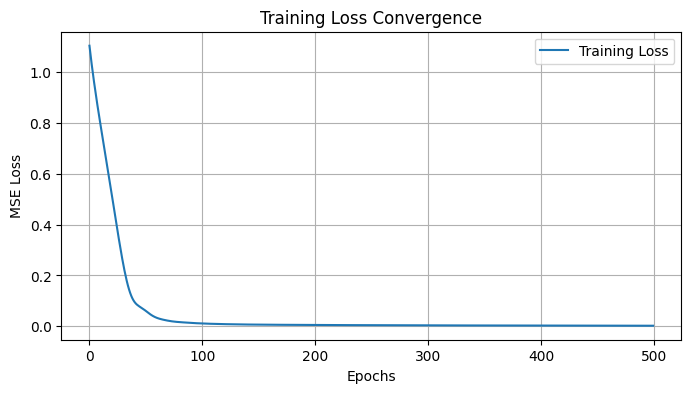

In [6]:
# Training Loop
epochs = 500
loss_history = []

model.train() # Set to training mode

for epoch in range(epochs):
    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad() # Clear gradients
    loss.backward()       # Compute gradients
    optimizer.step()      # Update weights
    
    loss_history.append(loss.item())
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. Model Evaluation
Now we evaluate the model on the Test Set (data the model has never seen). We must reverse the scaling transformation to interpret the results in real units (barrels).

In [7]:
model.eval() # Set to evaluation mode

with torch.no_grad():
    y_pred_scaled = model(X_test_tensor)
    
    # Inverse transform to get actual units (bbl)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.cpu().numpy())
    y_actual = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())

# Calculate Metrics
r2 = r2_score(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))

print(f"R-squared (R2): {r2:.4f}")
print(f"RMSE: {rmse:.2f} bbl")

R-squared (R2): 0.9969
RMSE: 14299.61 bbl


## 6. Visualization: Surrogate vs Simulator
A cross-plot of Predicted vs Actual values is the standard way to verify a surrogate model. A perfect model would align all points on the 45-degree line.

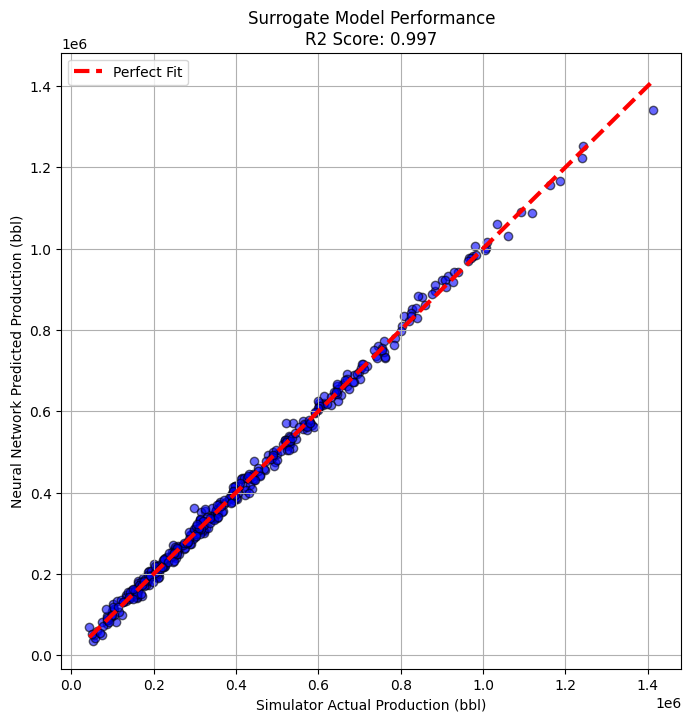

In [8]:
plt.figure(figsize=(8, 8))
plt.scatter(y_actual, y_pred, alpha=0.6, color='blue', edgecolors='k')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=3, label='Perfect Fit')

plt.title(f'Surrogate Model Performance\nR2 Score: {r2:.3f}')
plt.xlabel('Simulator Actual Production (bbl)')
plt.ylabel('Neural Network Predicted Production (bbl)')
plt.legend()
plt.grid(True)
plt.show()